In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:

"""
This function should process the video file.
Input: 
- file: the path to the video
Output:
- cut: vector of frame indices where cuts are detected
- grad: vector of tuples (start, end) of frame indices where gradations are detected
"""
def process_video(file: str):
    cut=[]
    grad=[]
    cap = cv2.VideoCapture(file)
    while(True):
        ret, frame = cap.read()
        if ret:
            grayFrame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            Gx, Gy = gradient_sobel(grayFrame)
            aretes = edge_extraction(Gx, Gy, 700)
            aretes_all.append(aretes)
        else:
            break
    cap.release()
    cv2.destroyAllWindows()
    return cut, grad

"""
This function provides the ground truth for a given video file.
Input: 
- file: the path to the video
Output:
- cut: vector of frame indices where cuts happen
- grad: vector of tuples (start, end) of frame indices where gradations happen
"""
def read_groundtruth(file: str):
    cut=[]
    grad=[]
    f = open(file, "r")
    line = f.readline().split()
    while(line != []):
        if len(line)==1:
            cut.append(int(line[0]))
        elif len(line)==2:
            grad.append([int(line[0]), int(line[1])])
        line = f.readline().split()
    return cut, grad

#cut, grad = process_video('anni005.mpg')
#gt_cut, gt_grad = read_groundtruth('anni005.txt')

#TODO : results analysis


In [3]:
def gradient_sobel(image):
    Gx = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=5) 
    Gy = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=5)
    
    return Gx, Gy

In [4]:
def edge_extraction(Gx, Gy, seuil):
    ForceGradient = np.sqrt(np.power(Gx,2)+np.power(Gy,2))
    aretes = ForceGradient>seuil
    
    return aretes

In [5]:
def dilatation(image):
    kernel = np.ones((3,3), np.uint8) 
    img_dilation = cv2.dilate(np.float32(image), kernel, iterations=1)
    
    return img_dilation

In [6]:
def compare(img1, img2):
    img1_dilated = dilatation(img1)
    img2_dilated = dilatation(img2)
    up = 0
    down = 0
    for i in range(len(img1_dilated)):
        up += np.dot(img1_dilated[i].astype(int), img2[i].astype(int))
    for i in range(len(img2)):
        for j in range(len(img2[0])):
            down += int(img2[i][j])
    pin = 1 - (up/down)
    up = 0
    down = 0
    for i in range(len(img1)):
        up += np.dot(img1[i].astype(int), img2_dilated[i].astype(int))
    for i in range(len(img1)):
        for j in range(len(img1[0])):
            down += int(img1[i][j])
    pout = 1 - (up/down)
    
    return [pin, pout]

In [7]:
def find_aretes(vid_path):
    cap = cv2.VideoCapture(vid_path)
    aretes_all = []
    while(True):
        ret, frame = cap.read()
        if ret:
            grayFrame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            Gx, Gy = gradient_sobel(grayFrame)
            aretes = edge_extraction(Gx, Gy, 700)
            aretes_all.append(aretes)
        else:
            break  

    cap.release()
    cv2.destroyAllWindows()
    
    return aretes_all

In [8]:
# BE CAREFUL THESE $ LINES TAKE FOREVER TO COMPILE
aretes_all = find_aretes("anni009/anni009.mpg")
anni009_rho = []
for i in range(len(aretes_all) - 1):
    anni009_rho.append(compare(aretes_all[i], aretes_all[i+1]))

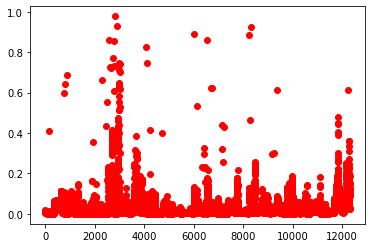

In [10]:
x = list(range(len(aretes_all)-1))
pin_list = [rho[0] for rho in anni009_rho]
plt.plot(x, pin_list, "ro")


In [76]:
def find_transitions(res):
    cut=[]
    grad=[]
    seuil = 0.2

    for i in range(len(res) - 1):
        depart = i
        if (res[i + 1] - res[depart] > seuil):
            interval = 0
            for j in range(i, len(res) - 1):
                if (res[j + 1] - res[depart] <= seuil):
                    break
                else:
                    interval = interval + 1
            if (interval > 1):
                grad.append([depart, depart + interval])
                i = i + interval
            else:
                cut.append(depart)
    
    return cut, grad

def getCutsDetected(pred, real):
    count = 0
    
    detect = set(pred)
    truth = set(real)
    
    for val in detect:
        r = range(val - 1, val + 2)
        for ex in r:
            if ex in truth:
                count = count + 1
    
    return count

def getTransitionsDetected(pred, real):
    count = 0
    
    realfirst = []
    realsecond = []
    
    for r in real:
        realfirst.append(r[0])
        realsecond.append(r[1])

    
    for grad in pred:
        first = grad[0]
        second = grad[1]
        fr = range(first - 2, first + 3)
        sr = range(second - 2, second + 3)
        
        for f in fr:
            for i in range (len(realfirst)):
                if (f == realfirst[i]):
                    for s in sr:
                        if (realsecond[i] == s):
                            count = count + 1;
                            break;
                        
    return count

In [77]:
cut, grad = find_transitions(pin_list)
gt_cut, gt_grad = read_groundtruth('anni009/anni009.txt')

print(getCutsDetected(cut, gt_cut))
print(len(cut))
print(len(gt_cut))

print(getTransitionsDetected(grad, gt_grad))
print(len(grad))
print(len(gt_grad))

31
48
38
0
21
65
